In [3]:
#!pip3 install transformers optimum[onnxruntime-gpu] evaluate datasets

In [5]:
import torch

In [6]:
import onnxruntime as rt
from pathlib import Path
import timeit
from copy import deepcopy
from onnxruntime import InferenceSession
from onnxruntime.transformers.optimizer import optimize_model
from optimum.onnxruntime import ORTModelForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

/data1/ViTgpt2/gpt2env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def benchmark(f, name=""):
    # warmup
    for _ in range(10):
        f()
    seconds_per_iter = timeit.timeit(f, number=100) / 100
    print(
        f"{name}:",
        f"{seconds_per_iter * 1000:.3f} ms",
    )


In [8]:
model_base_id = "madlag/bert-large-uncased-whole-word-masking-finetuned-squadv2"
model_pruned_id = "madlag/bert-large-uncased-wwm-squadv2-x2.63-f82.6-d16-hybrid-v1"
device = "cuda"

In [9]:
cuda_available = torch.cuda.is_available()
cudnn_available = torch.backends.cudnn.enabled
print(cuda_available)
print(cudnn_available)

True
True


In [10]:
import onnxruntime
onnxruntime.get_available_providers()

['TensorrtExecutionProvider',
 'CUDAExecutionProvider',
 'AzureExecutionProvider',
 'CPUExecutionProvider']

In [11]:
model_path = Path("models/bert")
tokenizer_base = AutoTokenizer.from_pretrained(model_base_id)
model = AutoModelForQuestionAnswering.from_pretrained(model_base_id).to(device)
model.save_pretrained(model_path)

In [12]:
model_pruned_path = Path("models/bert_pruned")
tokenizer_pruned = AutoTokenizer.from_pretrained(model_pruned_id)
model_pruned = AutoModelForQuestionAnswering.from_pretrained(model_pruned_id).to(device)
model_pruned.save_pretrained(model_pruned_path)

In [13]:
model_onnx_path = Path("models/bert_onnx_pruned")
model_onnx = ORTModelForQuestionAnswering.from_pretrained(model_pruned_id, export=True, provider="CUDAExecutionProvider")
model_onnx.save_pretrained(model_onnx_path)

Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
	- default: The default ONNX variant.
Using framework PyTorch: 2.0.1+cu118
Overriding 1 configuration item(s)
	- use_cache -> False


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



2023-10-10 17:27:53.992043550 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-10-10 17:27:53.992067031 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [14]:
optimized_onnx_path = str(model_onnx_path / "optimized.onnx")
optimized_model = optimize_model(input=str(model_onnx_path / "model.onnx"), model_type="bert", use_gpu=True)
optimized_model.save_model_to_file(optimized_onnx_path)

2023-10-10 17:29:00.070931560 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-10-10 17:29:00.070946915 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Input hidden size (448) is not same as weight matrix dimension of q,k,v (1024). Please provide a correct input hidden size or pass in 0
Input hidden size (448) is not same as weight matrix dimension of q,k,v (1024). Please provide a correct input hidden size or pass in 0
Input hidden size (192) is not same as weight matrix dimension of q,k,v (1024). Please provide a correct input hidden size or pass in 0
Input hidden size (320) is not same as weight matrix dimension of q,k,v (1024). Please provide a correct input h

In [15]:
optimized_fp16_model_path = str(model_onnx_path / "optimized_fp16.onnx")
optimized_fp16_model = deepcopy(optimized_model)
optimized_fp16_model.convert_float_to_float16()
optimized_fp16_model.save_model_to_file(optimized_fp16_model_path)

In [16]:
question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
inputs_base = tokenizer_base(question, text, return_tensors="pt").to(device)
inputs = tokenizer_pruned(question, text, return_tensors="pt").to(device)
inputs_onnx = dict(tokenizer_pruned(question, text, return_tensors="np"))

In [17]:
!ls -lh --block-size=M ./models/bert

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 1275M
-rwxrwxrwx 1 root root    1M Οκτ  10 17:25 config.json
-rwxrwxrwx 1 root root 1275M Οκτ  10 17:25 pytorch_model.bin


In [18]:
!ls -lh --block-size=M ./models/bert_pruned

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 1085M
-rwxrwxrwx 1 root root    1M Οκτ  10 17:27 config.json
-rwxrwxrwx 1 root root 1085M Οκτ  10 17:27 pytorch_model.bin


In [19]:
!ls -lh --block-size=M ./models/bert_onnx_pruned

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 2723M
-rwxrwxrwx 1 root root    1M Οκτ  10 17:27 config.json
-rwxrwxrwx 1 root root 1085M Οκτ  10 17:28 model.onnx
-rwxrwxrwx 1 root root  553M Οκτ  10 17:30 optimized_fp16.onnx
-rwxrwxrwx 1 root root 1085M Οκτ  10 17:29 optimized.onnx
-rwxrwxrwx 1 root root    1M Οκτ  10 17:27 special_tokens_map.json
-rwxrwxrwx 1 root root    1M Οκτ  10 17:27 tokenizer_config.json
-rwxrwxrwx 1 root root    1M Οκτ  10 17:27 tokenizer.json
-rwxrwxrwx 1 root root    1M Οκτ  10 17:27 vocab.txt


In [20]:
import onnxruntime as ort
ort.get_device()

'GPU'

In [21]:
ort.get_available_providers()

['TensorrtExecutionProvider',
 'CUDAExecutionProvider',
 'AzureExecutionProvider',
 'CPUExecutionProvider']

In [ ]:
providers=["TensorrtExecutionProvider", "CUDAExecutionProvider"]
sess = InferenceSession(str(model_onnx_path / "model.onnx"), providers=providers)
optimized_sess = InferenceSession(str(model_onnx_path / "optimized.onnx"), providers=providers)
optimized_fp16_sess = InferenceSession(
    str(model_onnx_path / "optimized_fp16.onnx"), providers=providers
)

In [23]:
# %% Test inference times for all variants
benchmark(lambda: model(**inputs_base), "Pytorch")
benchmark(lambda: model_pruned(**inputs), "Pruned Pytorch")
benchmark(lambda: sess.run(None, input_feed=inputs_onnx), "Pruned ONNX")
benchmark(lambda: optimized_sess.run(None, input_feed=inputs_onnx), "Pruned ONNX optimized")
benchmark(lambda: optimized_fp16_sess.run(None, input_feed=inputs_onnx), "Pruned ONNX optimized fp16")

Pytorch: 15.631 ms
Pruned Pytorch: 15.736 ms
Pruned ONNX: 3.538 ms
Pruned ONNX optimized: 2.387 ms
Pruned ONNX optimized fp16: 2.096 ms


In [24]:
MAX_SEQUENCE_LENGTH=512
for n in [1, 4, 64, 256, 512]:
    print(f"====== Tokens {n} ======")
    txt = " ".join(["word"] * n)

    pt_inputs_base = tokenizer_base(question, txt, max_length=MAX_SEQUENCE_LENGTH, return_tensors="pt").to(device)
    pt_inputs = tokenizer_pruned(question, txt, max_length=MAX_SEQUENCE_LENGTH, return_tensors="pt").to(device)
    ort_inputs = dict(tokenizer_pruned(question, txt, max_length=MAX_SEQUENCE_LENGTH, return_tensors="np"))

    benchmark(lambda: model(**pt_inputs), f"Pytorch ({n} tokens)")
    benchmark(lambda: model_pruned(**pt_inputs), f"Pruned Pytorch ({n} tokens)")
    benchmark(lambda: sess.run(None, ort_inputs), f"Pruned ONNX ({n} tokens)")
    benchmark(lambda: optimized_sess.run(None, ort_inputs), f"Pruned ONNX optimized ({n} tokens)")
    benchmark(
        lambda: optimized_fp16_sess.run(None, ort_inputs),
        f"Pruned ONNX optimized fp16 ({n} tokens)",
    )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


====== Tokens 1 ======
Pytorch (1 tokens): 15.584 ms
Pruned Pytorch (1 tokens): 15.582 ms
Pruned ONNX (1 tokens): 3.514 ms
Pruned ONNX optimized (1 tokens): 2.432 ms
Pruned ONNX optimized fp16 (1 tokens): 2.094 ms
====== Tokens 4 ======
Pytorch (4 tokens): 15.570 ms
Pruned Pytorch (4 tokens): 15.658 ms
Pruned ONNX (4 tokens): 3.592 ms
Pruned ONNX optimized (4 tokens): 2.452 ms
Pruned ONNX optimized fp16 (4 tokens): 2.102 ms
====== Tokens 64 ======
Pytorch (64 tokens): 16.132 ms
Pruned Pytorch (64 tokens): 16.509 ms
Pruned ONNX (64 tokens): 5.004 ms
Pruned ONNX optimized (64 tokens): 3.833 ms
Pruned ONNX optimized fp16 (64 tokens): 2.116 ms
====== Tokens 256 ======
Pytorch (256 tokens): 16.019 ms
Pruned Pytorch (256 tokens): 15.871 ms
Pruned ONNX (256 tokens): 10.106 ms
Pruned ONNX optimized (256 tokens): 9.041 ms
Pruned ONNX optimized fp16 (256 tokens): 4.606 ms
====== Tokens 512 ======
Pytorch (512 tokens): 28.163 ms
Pruned Pytorch (512 tokens): 21.023 ms
Pruned ONNX (512 tokens): 15.

In [25]:
from pathlib import Path
from optimum.onnxruntime import ORTModelForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from datasets import load_dataset
from evaluate import evaluator
from transformers import QuestionAnsweringPipeline
import pandas as pd

In [26]:
# Load the dataset for evaluation
data = load_dataset("squad_v2", split="validation").shuffle(seed=123).select(range(10000))
task_evaluator = evaluator("question-answering")
results = []
index = ["Base model", "Pruned", "ONNX", "ONNX Optimized", "ONNX Optimized FP16"]

Found cached dataset squad_v2 (/home/vcl3d/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)
Loading cached shuffled indices for dataset at /home/vcl3d/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-47b303506e027dc6.arrow


In [27]:
def evaluate_model(model, tokenizer):
  eval_results = task_evaluator.compute(
      model_or_pipeline=model,
      tokenizer=tokenizer,
      data=data,
      metric="squad_v2",
      squad_v2_format=True
  )
  return eval_results

In [26]:
# model_path = Path("models/bert/")
# device = "cuda"
# tokenizer = AutoTokenizer.from_pretrained("madlag/bert-large-uncased-wwm-squadv2-x2.63-f82.6-d16-hybrid-v1")
# model = ORTModelForQuestionAnswering.from_pretrained(model_path, file_name="model.onnx", provider='CUDAExecutionProvider').to(device)
# pipeline = QuestionAnsweringPipeline(model, tokenizer, task="question-answering")
# results.append(evaluate_model(pipeline, tokenizer))

In [28]:
model_path = Path("models/bert")
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained("madlag/bert-large-uncased-wwm-squadv2-x2.63-f82.6-d16-hybrid-v1")
model = AutoModelForQuestionAnswering.from_pretrained(model_path).to(device)
results.append(evaluate_model(model, tokenizer))

In [28]:
# model_pruned_path = Path("models/bert_pruned/")
# model_pruned = ORTModelForQuestionAnswering.from_pretrained(model_pruned_path, file_name="model.onnx", provider='TensorrtExecutionProvider').to(device)
# pipeline = QuestionAnsweringPipeline(model, tokenizer, task="question-answering")
# results.append(evaluate_model(pipeline, tokenizer))

In [29]:
model_pruned_path = Path("models/bert_pruned")
model_pruned = AutoModelForQuestionAnswering.from_pretrained(model_pruned_path).to(device)
results.append(evaluate_model(model_pruned, tokenizer))

In [30]:
model_files = ["model.onnx", "optimized.onnx", "optimized_fp16.onnx"]

for file_name in model_files:
  onnx_model = ORTModelForQuestionAnswering.from_pretrained("models/bert_onnx_pruned/", file_name=file_name, provider='CUDAExecutionProvider').to(device)
  pipeline = QuestionAnsweringPipeline(onnx_model, tokenizer, task="question-answering")
  results.append(evaluate_model(pipeline, tokenizer))


2023-10-10 17:45:25.382745082 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-10-10 17:45:25.382765581 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2023-10-10 17:45:26.297321034 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-10-10 17:45:26.297336322 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
The ONNX file optimized.onnx is not a re

In [62]:
results_df = pd.DataFrame(results, index=index)
res = results_df[["best_f1","latency_in_seconds"]]
res

,best_f1,latency_in_seconds
Base model,86.078114,0.015008
Pruned,82.667436,0.014359
ONNX,82.670769,0.009796
ONNX Optimized,82.667436,0.008509
ONNX Optimized FP16,82.658651,0.005555


In [76]:
import os
model_size = []
model_file_path = '/data1/ViTgpt2/models/bert/pytorch_model.bin'  
size_in_bytes = os.path.getsize(model_file_path)
size_in_gigabytes = size_in_bytes / 1073741824
model_size.append(size_in_gigabytes)

model_file_path = '/data1/ViTgpt2/models/bert_pruned/pytorch_model.bin'  
size_in_bytes = os.path.getsize(model_file_path)
size_in_gigabytes = size_in_bytes / 1073741824
model_size.append(size_in_gigabytes)

model_file_path = '/data1/ViTgpt2/models/bert_onnx_pruned/model.onnx'  
size_in_bytes = os.path.getsize(model_file_path)
size_in_gigabytes = size_in_bytes / 1073741824
model_size.append(size_in_gigabytes)

model_file_path = '/data1/ViTgpt2/models/bert_onnx_pruned/optimized.onnx'  
size_in_bytes = os.path.getsize(model_file_path)
size_in_gigabytes = size_in_bytes / 1073741824
model_size.append(size_in_gigabytes)

model_file_path = '/data1/ViTgpt2/models/bert_onnx_pruned/optimized_fp16.onnx'  
size_in_bytes = os.path.getsize(model_file_path)
size_in_gigabytes = size_in_bytes / 1073741824
model_size.append(size_in_gigabytes)

model_size

[1.244727117009461,
 1.059044343419373,
 1.05940649099648,
 1.0589743750169873,
 0.5395128857344389]

In [80]:
res["model size"] = model_size
res

/tmp/ipykernel_70645/26171772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["model size"] = model_size


,best_f1,latency_in_seconds,model size
Base model,86.078114,0.015008,1.244727
Pruned,82.667436,0.014359,1.059044
ONNX,82.670769,0.009796,1.059406
ONNX Optimized,82.667436,0.008509,1.058974
ONNX Optimized FP16,82.658651,0.005555,0.539513


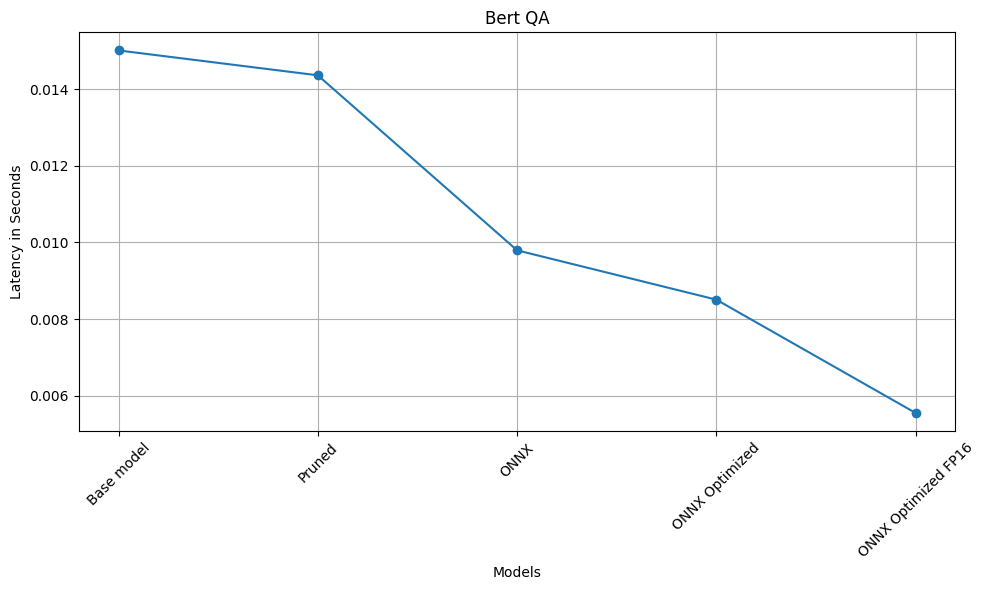

In [84]:
model_names = res.index
latency_values = res['latency_in_seconds']

plt.figure(figsize=(10, 6))
plt.plot(model_names, latency_values, marker='o', linestyle='-')
plt.xlabel('Models')
plt.ylabel('Latency in Seconds')
plt.title('Bert QA')
plt.xticks(rotation=45)  


plt.tight_layout()
plt.grid(True)
plt.show()

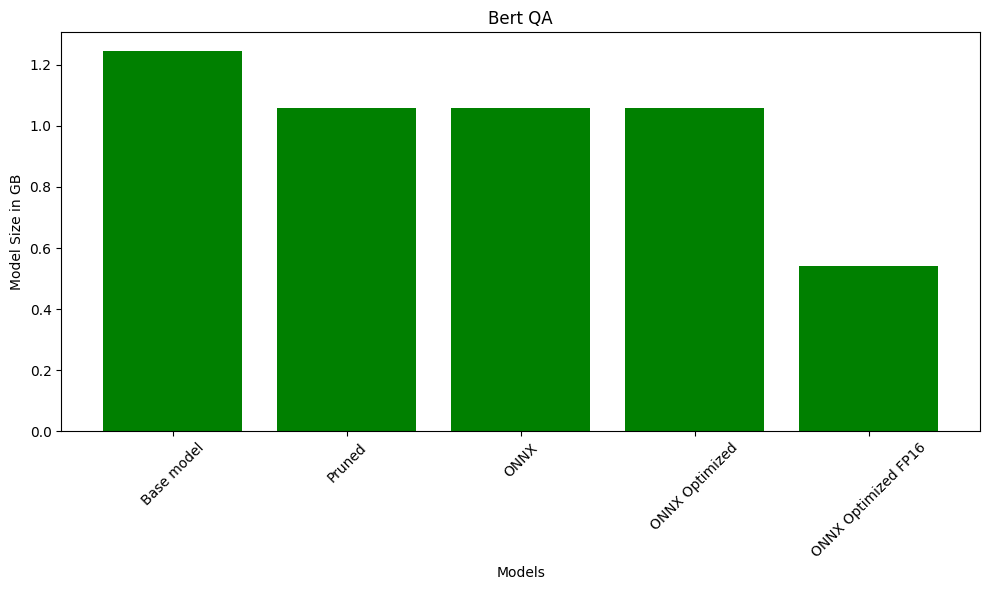

In [82]:
import matplotlib.pyplot as plt

# Extract the data for the plot
model_names = res.index
model_sizes = res['model size']

# Create a bar plot for model size
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_sizes, color='green')
plt.xlabel('Models')
plt.ylabel('Model Size in GB')
plt.title('Bert QA')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()


In [35]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "/data1/ViTgpt2/models/bert"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': "What is VOXReality?",
    'context': "VOXReality is a great project"
}

In [38]:
res = nlp(QA_input)
res

{'score': 0.9116794466972351,
 'start': 14,
 'end': 29,
 'answer': 'a great project'}

In [37]:
from transformers import AutoTokenizer, pipeline
from optimum.onnxruntime import ORTModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("/data1/ViTgpt2/models/bert_onnx_pruned")
model = ORTModelForQuestionAnswering.from_pretrained("/data1/ViTgpt2/models/bert_onnx_pruned")
onnx_qa = pipeline("question-answering", model=model, tokenizer=tokenizer)

question, text = "What is VOXReality?", "VOXReality is a great project"


In [39]:
pred = onnx_qa(QA_input)
pred

{'score': 0.9354177713394165,
 'start': 14,
 'end': 29,
 'answer': 'a great project'}